In [ ]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from captum.attr import DeepLift

model = torch.load("/content/drive/MyDrive/NFV/server.pt")


def attribute_features(algorithm, input, target, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=target, **kwargs)
    return tensor_attributions


def strtoarray(inp):
    inp = inp.replace('[', '')
    inp = inp.replace(']', '')
    inp = inp.split()
    return [float(x) for x in inp]


# to avoid dimension errors
def model_input(inp):
    return torch.tensor([inp])

def string_tensor_to_nb(text):
  text = text.split('tensor(')
  text = text[1].split(".")
  text = text[0].split(")")
  return int(text[0])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [ ]:
data_points = pd.read_csv("/content/drive/MyDrive/NFV/TEST DATA FROM SERVER/data2_test_server.csv")
data_points['server_input_array'] = data_points.apply(lambda row: strtoarray(row['server_input']), axis=1)
data_points['server_input_torch'] = data_points.apply(lambda row: model_input(row['server_input_array']), axis=1)
data_points['pred label'] = data_points.apply(lambda row: string_tensor_to_nb(row['pred label']), axis=1)
data_points['original label'] = data_points.apply(lambda row: string_tensor_to_nb(row['original label']), axis=1)

In [ ]:
data_points['failure node'].unique()

array(['0', 'TR-02', 'IntGW-02', 'IntGW-01', 'TR-01', 'RR-01'],
      dtype=object)

Before removing missclassified points 1082


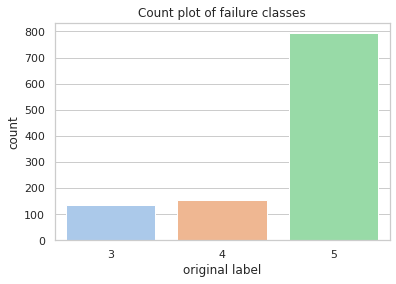

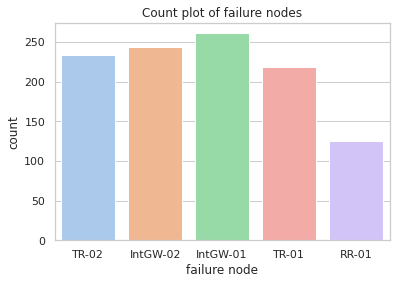

TR-01 218
TR-02 234
IntGW-01 261
IntGW-02 244
RR-01 125
After removing missclassified points 761


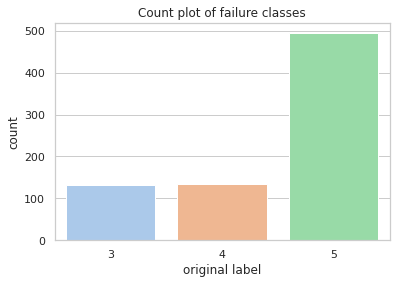

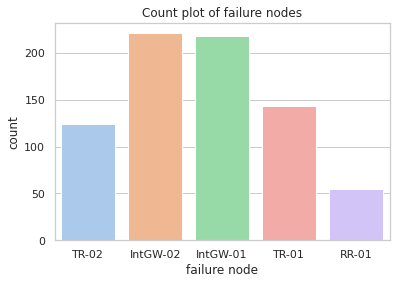

In [ ]:
data_points = data_points[data_points['original label'] > 0] # removing the normal class (no failure)
data_points = data_points[data_points['failure node'] != '0'] # removing the localisatio of 0
print("Before removing missclassified points", str(len(data_points)))
ax = sns.countplot(x="original label", data=data_points)
plt.title("Count plot of failure classes")
plt.show()
ax = sns.countplot(x="failure node", data=data_points)
plt.title("Count plot of failure nodes")
plt.show()

print("TR-01", len(data_points[data_points['failure node'] =='TR-01']))
print("TR-02", len(data_points[data_points['failure node'] =='TR-02']))
print("IntGW-01", len(data_points[data_points['failure node'] =='IntGW-01']))
print("IntGW-02", len(data_points[data_points['failure node'] =='IntGW-02']))
print("RR-01", len(data_points[data_points['failure node'] =='RR-01']))


data_points = data_points[data_points['pred label'] == data_points['original label']]
print("After removing missclassified points", str(len(data_points)))
ax = sns.countplot(x="original label", data=data_points)
plt.title("Count plot of failure classes")
plt.show()
ax = sns.countplot(x="failure node", data=data_points)
plt.title("Count plot of failure nodes")
plt.show()

In [ ]:
data_points['failure node'].unique()

array(['TR-01', 'TR-02', 'IntGW-02', 'IntGW-01', 'RR-01'], dtype=object)

In [ ]:
IntGW_01_nodes = data_points[data_points['failure node'] == 'IntGW-01'].reset_index(drop=True)
point_to_be_explained = IntGW_01_nodes.loc[1]
input = model_input(point_to_be_explained['server_input_array'])
print("Input shape", input.shape)
print("Original label: "+ str(point_to_be_explained['original label']))
print("Predicted label: "+str(point_to_be_explained['pred label']))
print("Failure Node: " + str(point_to_be_explained['failure node']))

pred = model(input)
_, label = pred.max(dim=1)

Input shape torch.Size([1, 320])
Original label: 5
Predicted label: 5
Failure Node: IntGW-01


In [ ]:
# 0 - 64: admin       - label 0
# 64 - 128: INTGW_01  - label 1
# 128 - 192: INTGW_02 - label 2
# 192 - 256: RR_01    - label 3
# 256 - 320: TR_01_02 - label 4

from captum.attr import IntegratedGradients, NoiseTunnel, GradientShap, DeepLiftShap
#dl = GradientShap(model)
dl = IntegratedGradients(model) # -> BEST RESULTS
#dl = NoiseTunnel(dl)
#dl = DeepLift(model)
#dl = DeepLiftShap(model)
topK_threshold = 3

In [ ]:
all_test_labels = []
all_pred_labels = []
all_pred_accuracies = dict()

In [ ]:
#'IntGW-01', '0', 'TR-02', 'IntGW-02', 'TR-01', 'RR-01']
IntGW_01_nodes = data_points[data_points['failure node'] == 'IntGW-01'].reset_index(drop=True)
localisation_based_on_explanation = 0
for i in range(len(IntGW_01_nodes)):
  results = []
  point_to_be_explained = IntGW_01_nodes.loc[i]
  input = model_input(point_to_be_explained['server_input_array'])
  pred = model(input)
  _, label = pred.max(dim=1)
  attr_dl = attribute_features(dl, input, label, baselines=input * 0)
  top_attr_position = torch.topk(attr_dl, topK_threshold).indices
  cond_1 = top_attr_position[top_attr_position >= 0]
  cond_2 = cond_1[cond_1 < 64]
  print("Admin neurons:",len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 64]
  cond_2 = cond_1[cond_1 < 128]
  print("INTGW_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 128]
  cond_2 = cond_1[cond_1 < 192]
  print("INTGW_02 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 192]
  cond_2 = cond_1[cond_1 < 256]
  print("RR_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 256]
  cond_2 = cond_1[cond_1 < 320]
  print("TR_01_02 neurons:", len(cond_2))
  results.append(len(cond_2))
  print(results)

  most_infulencing_node = np.max(results)

  if results[1] == most_infulencing_node:
    localisation_based_on_explanation +=1
    all_test_labels.append(1)
    all_pred_labels.append(1)
  else:
    all_test_labels.append(1)
    all_pred_labels.append(np.argmax(results))



  print("#######################")
print(len(IntGW_01_nodes))
all_pred_accuracies['INGW-01'] = localisation_based_on_explanation / len(IntGW_01_nodes) * 100
print(all_pred_accuracies['INGW-01'])

Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 1
INTGW_02 neurons: 0
RR_01 neurons: 2
TR_01_02 neurons: 0
[0, 1, 0, 2, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 3
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 3, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 2
INTGW_02 neurons: 0
RR_01

In [ ]:
#'IntGW-01', '0', 'TR-02', 'IntGW-02', 'TR-01', 'RR-01']
localisation_based_on_explanation = 0
IntGW_02_nodes = data_points[data_points['failure node'] == 'IntGW-02'].reset_index(drop=True)
for i in range(len(IntGW_02_nodes)):
  results = []
  point_to_be_explained = IntGW_02_nodes.loc[i]
  input = model_input(point_to_be_explained['server_input_array'])
  pred = model(input)
  _, label = pred.max(dim=1)
  attr_dl = attribute_features(dl, input, label, baselines=input * 0)
  top_attr_position = torch.topk(attr_dl, topK_threshold).indices

  cond_1 = top_attr_position[top_attr_position >= 0]
  cond_2 = cond_1[cond_1 < 64]
  print("Admin neurons:",len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 64]
  cond_2 = cond_1[cond_1 < 128]
  print("INTGW_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 128]
  cond_2 = cond_1[cond_1 < 192]
  print("INTGW_02 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 192]
  cond_2 = cond_1[cond_1 < 256]
  print("RR_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 256]
  cond_2 = cond_1[cond_1 < 320]
  print("TR_01_02 neurons:", len(cond_2))
  results.append(len(cond_2))
  print(results)

  most_infulencing_node = np.max(results)

  if results[2] == most_infulencing_node:
    localisation_based_on_explanation +=1
    all_test_labels.append(2)
    all_pred_labels.append(2)
  else:
    all_test_labels.append(2)
    all_pred_labels.append(np.argmax(results))
  print("#######################")

print(len(IntGW_02_nodes))
all_pred_accuracies['INGW-02'] = localisation_based_on_explanation / len(IntGW_02_nodes) * 100
print(all_pred_accuracies['INGW-02'])

Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 2
RR_01 neurons: 0
TR_01_02 neurons: 1
[0, 0, 2, 0, 1]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 3
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 0, 3, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 3
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 0, 3, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 1
INTGW_02 neurons: 2
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 1, 2, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 3
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 0, 3, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 3
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 0, 3, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 3
RR_01 neurons: 0
TR_01_02 neurons: 0
[0, 0, 3, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 1
INTGW_02 neurons: 2
RR_01

In [ ]:
#'IntGW-01', '0', 'TR-02', 'IntGW-02', 'TR-01', 'RR-01']
localisation_based_on_explanation = 0
RR_01_nodes = data_points[data_points['failure node'] == 'RR-01'].reset_index(drop=True)
for i in range(len(RR_01_nodes)):
  results = []
  point_to_be_explained = RR_01_nodes.loc[i]
  input = model_input(point_to_be_explained['server_input_array'])
  pred = model(input)
  _, label = pred.max(dim=1)
  attr_dl = attribute_features(dl, input, label, baselines=input * 0)
  top_attr_position = torch.topk(attr_dl, topK_threshold).indices

  cond_1 = top_attr_position[top_attr_position >= 0]
  cond_2 = cond_1[cond_1 < 64]
  print("Admin neurons:",len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 64]
  cond_2 = cond_1[cond_1 < 128]
  print("INTGW_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 128]
  cond_2 = cond_1[cond_1 < 192]
  print("INTGW_02 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 192]
  cond_2 = cond_1[cond_1 < 256]
  print("RR_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 256]
  cond_2 = cond_1[cond_1 < 320]
  print("TR_01_02 neurons:", len(cond_2))
  results.append(len(cond_2))
  print(results)

  most_infulencing_node = np.max(results)

  if results[3] == most_infulencing_node:
    localisation_based_on_explanation +=1
    all_test_labels.append(3)
    all_pred_labels.append(3)
  else:
    all_test_labels.append(3)
    all_pred_labels.append(np.argmax(results))
  print("#######################")
print(len(RR_01_nodes))
print(localisation_based_on_explanation / len(RR_01_nodes) * 100)


print(len(RR_01_nodes))
all_pred_accuracies['RR-01'] = localisation_based_on_explanation / len(RR_01_nodes) * 100
print(all_pred_accuracies['RR-01'])

Admin neurons: 3
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[3, 0, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 3
[0, 0, 0, 0, 3]
#######################
Admin neurons: 3
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[3, 0, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 3
TR_01_02 neurons: 0
[0, 0, 0, 3, 0]
#######################
4
25.0
4
25.0


In [ ]:
#'IntGW-01', '0', 'TR-02', 'IntGW-02', 'TR-01', 'RR-01']
localisation_based_on_explanation = 0
TR_01_02_nodes = data_points[(data_points['failure node'] == 'TR-02') | (data_points['failure node'] == 'TR-01')].reset_index(drop=True)
for i in range(len(TR_01_02_nodes)):
  results = []
  point_to_be_explained = TR_01_02_nodes.loc[i]
  input = model_input(point_to_be_explained['server_input_array'])
  pred = model(input)
  _, label = pred.max(dim=1)
  attr_dl = attribute_features(dl, input, label, baselines=input * 0)
  top_attr_position = torch.topk(attr_dl, topK_threshold).indices

  cond_1 = top_attr_position[top_attr_position >= 0]
  cond_2 = cond_1[cond_1 < 64]
  print("Admin neurons:",len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 64]
  cond_2 = cond_1[cond_1 < 128]
  print("INTGW_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 128]
  cond_2 = cond_1[cond_1 < 192]
  print("INTGW_02 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 192]
  cond_2 = cond_1[cond_1 < 256]
  print("RR_01 neurons:", len(cond_2))
  results.append(len(cond_2))

  cond_1 = top_attr_position[top_attr_position >= 256]
  cond_2 = cond_1[cond_1 < 320]
  print("TR_01_02 neurons:", len(cond_2))
  results.append(len(cond_2))
  print(results)

  most_infulencing_node = np.max(results)

  if results[4] == most_infulencing_node:
    localisation_based_on_explanation +=1
    all_test_labels.append(4)
    all_pred_labels.append(4)
  else:
    all_test_labels.append(4)
    all_pred_labels.append(np.argmax(results))
  print("#######################")

print(len(TR_01_02_nodes))
print(localisation_based_on_explanation / len(TR_01_02_nodes) * 100)

print(len(TR_01_02_nodes))
all_pred_accuracies['TR-01-02'] = localisation_based_on_explanation / len(TR_01_02_nodes) * 100
print(all_pred_accuracies['TR-01-02'])

Admin neurons: 0
INTGW_01 neurons: 1
INTGW_02 neurons: 1
RR_01 neurons: 0
TR_01_02 neurons: 1
[0, 1, 1, 0, 1]
#######################
Admin neurons: 3
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 0
[3, 0, 0, 0, 0]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 3
[0, 0, 0, 0, 3]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 3
[0, 0, 0, 0, 3]
#######################
Admin neurons: 0
INTGW_01 neurons: 1
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 2
[0, 1, 0, 0, 2]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 3
[0, 0, 0, 0, 3]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 0
RR_01 neurons: 0
TR_01_02 neurons: 3
[0, 0, 0, 0, 3]
#######################
Admin neurons: 0
INTGW_01 neurons: 0
INTGW_02 neurons: 1
RR_01

In [ ]:
import sklearn.metrics as mt
events = {
    'admin': 0,
    'INTGW-01': 1,
    'INTGW-02': 2,
    'RR-01': 3,
    'TR-01-02': 4
}
print(mt.classification_report(all_test_labels, all_pred_labels, target_names=list(events.keys())))

              precision    recall  f1-score   support

       admin       0.00      0.00      0.00         0
    INTGW-01       0.88      0.96      0.92        51
    INTGW-02       0.75      0.90      0.82        42
       RR-01       0.25      0.25      0.25         4
    TR-01-02       0.96      0.65      0.77        66

    accuracy                           0.80       163
   macro avg       0.57      0.55      0.55       163
weighted avg       0.86      0.80      0.82       163



In [ ]:
print("Localisation Accuracy per Node:")
print(all_pred_accuracies)

Localisation Accuracy per Node:
{'INGW-01': 96.07843137254902, 'INGW-02': 90.47619047619048, 'RR-01': 25.0, 'TR-01-02': 65.15151515151516}
